You are provided with a tabular dataset containing 19 predictor features and 1 continuous target variable. Your task is to build a neural network in keras/tensorflow to predict the target variable. The data is separated into a train set of 1875 data samples, and a test set of 625 data samples.

The jupyter notebook should contain the following elements:

- Preprocessing of your datasets according to the requirements of neural networks. (different features have different descriptive statistics!)
- Implementation of 3 benchmark models: a linear model, a tree-based model and a neural network that has not been tuned. 
- Tuning of a neural network using a hyperparameter optimization library of your choice. The code for hyperparameter tuning should include regularization. 
- A well annotated plot showing the train vs. validation loss of the best performing neural network. Based on the plot you should interpret the model fit with max. 2 sentences. Anything beyond these 2 sentences will not participate in the evaluation!
- Additionally, you should provide an interpretation of why you believe the best performing architecture is suitable for your task in max. 3 sentences.
- A table showing all results (on a validation subset) from the tuned network and your benchmarks.
- Well documented code, which is divided into functions, classes, etc.

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from sklearn.metrics import mean_squared_error

import optuna
import tensorflow as tf
from tensorflow.keras import regularizers
from sklearn.preprocessing import StandardScaler

First：Data uploading

In [21]:

#Predictor features on the train set:
train_X=pd.read_csv('train_X.csv',sep=',',header=0,index_col=0)
#Target variable on the train set:
train_y=pd.read_csv('train_y.csv',sep=',',header=0,index_col=0)
#Predictor features on the test set:
test_X=pd.read_csv('test_X.csv',sep=',',header=0,index_col=0)
#Demo predictions file:
demo_predictions=pd.read_csv('Demo_Predictions.csv',sep=',',header=0,index_col=0)

Second:Data spliting

In [22]:
#split the original training set 
# into sub-training set (80%)for training the model parameters) 
# and validation set (20%) for tuning hyperparameters
from sklearn.model_selection import train_test_split


x_subtrain_train, x_val_train, y_subtrain_train, y_val_train = train_test_split(
    train_X, train_y, test_size=0.2, shuffle=True, random_state=42
)


Third：

In [23]:
#scale x and y
from sklearn.preprocessing import StandardScaler
x_scalar = StandardScaler()
x_subtrain_train_scaled=x_scalar.fit_transform(x_subtrain_train)
x_val_train_scaled =x_scalar.transform(x_val_train)
x_test_scaled=x_scalar.transform(test_X)

y_scalar = StandardScaler()
y_subtrain_train_scaled=y_scalar.fit_transform(y_subtrain_train.values.reshape(-1, 1))
y_val_train_scaled=y_scalar.transform(y_val_train.values.reshape(-1, 1))



The first benchmark: Ridge regression

In [24]:
#the first benchmark linear model
#pearson correlation 
import pandas as pd

# Assuming X is your DataFrame of features
correlation_matrix = train_X.corr(method='pearson')

print(correlation_matrix)

           1         2         3         4         5         6         7  \
1   1.000000  0.655096 -0.524821  0.973878  0.464945  0.010382 -0.378565   
2   0.655096  1.000000 -0.853540  0.623291  0.827375 -0.027750 -0.361367   
3  -0.524821 -0.853540  1.000000 -0.483147 -0.597238 -0.009859  0.324112   
4   0.973878  0.623291 -0.483147  1.000000  0.366328 -0.015168 -0.396542   
5   0.464945  0.827375 -0.597238  0.366328  1.000000 -0.024547 -0.159408   
6   0.010382 -0.027750 -0.009859 -0.015168 -0.024547  1.000000  0.000112   
7  -0.378565 -0.361367  0.324112 -0.396542 -0.159408  0.000112  1.000000   
8  -0.823443 -0.634933  0.480116 -0.882598 -0.361349 -0.005224  0.506974   
9  -0.036005 -0.041030 -0.003644 -0.031394 -0.057901 -0.038841  0.007337   
10 -0.494435 -0.452051  0.207982 -0.544791 -0.320963  0.033682  0.212477   
11 -0.012211  0.030721 -0.007077 -0.007133  0.018431  0.012251 -0.025603   
12 -0.126812 -0.682921  0.651756 -0.006929 -0.840684  0.016807  0.011020   
13  0.938543

In [ ]:
#from the correlation table, we can easily some highly related parameters
#I use Ridge to treat potential multicollinearity
from sklearn.linear_model import RidgeCV
import numpy as np
from sklearn import linear_model
reg = linear_model.RidgeCV(alphas=np.linspace(0.01, 100, 2000))
reg.fit(x_subtrain_train_scaled, y_subtrain_train.values.ravel())

print("Best alpha:", reg.alpha_)

Best alpha: 0.110040020010005


In [26]:
# we set up our ridge regression
reg = linear_model.Ridge(alpha=.11)
reg.fit(x_subtrain_train_scaled, y_subtrain_train_scaled)

reg.coef_

reg.intercept_
print("coefs:", reg.coef_
      )
print("intercept:", reg.intercept_)

coefs: [[-0.19933268  0.06840095  0.88547204  0.49093417  0.16434762  0.00825083
  -0.04078904 -0.05364764 -0.00482149  0.05728051 -0.00090782  0.17537197
   0.02931285 -0.17585513  0.13288882  0.47480467 -0.07856005 -0.00215498
   0.02873281]]
intercept: [6.40328274e-18]


In [28]:
from sklearn.metrics import mean_squared_error

# Predict on the validation set
y_val_pred_ridge = reg.predict(x_val_train_scaled)

# Reshape predictions
y_val_pred_scaled =y_val_pred_ridge.reshape(-1, 1)

# Calculate MSE
y_val_true_ridge = y_scalar.inverse_transform(y_val_train_scaled)
y_val_pred_ridge = y_scalar.inverse_transform(y_val_pred_scaled)
mse_val = mean_squared_error(y_val_true_ridge, y_val_pred_ridge)
rmse_val = np.sqrt(mse_val)

print("Validation MSE from Ridge:", mse_val)
print("Validation_RMSE_Ridge:", rmse_val)
Validation_RMSE_Ridge = rmse_val 

Validation MSE from Ridge: 1567.0363761575486
Validation_RMSE_Ridge: 39.585810288000275


The second benchmark-- random forest

In [29]:
#loading 
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


In [107]:
#tuning the hyper parameters in random forest
param_dist = {
    'n_estimators': randint(20, 200),
    'max_depth': randint(10,200),
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]

}

random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(),
    param_distributions=param_dist,
    n_iter=200,  #how many protential combinations explored
    scoring='neg_mean_squared_error',
    cv=5,
    random_state=20
)
#fit our training data 
random_search.fit(x_subtrain_train_scaled, y_subtrain_train_scaled)

# Print the best parameters found
print("Best parameters:", random_search.best_params_)



/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,),

Best parameters: {'bootstrap': False, 'max_depth': 188, 'max_features': 'log2', 'n_estimators': 146}


In [30]:
#model the random forest based on the hyperparameters

Random_forest= RandomForestRegressor(
    bootstrap=False,
    max_depth=19,
    max_features='sqrt',
    n_estimators=179,
    random_state=20
)

Random_forest.fit(x_subtrain_train_scaled, y_subtrain_train_scaled)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(bootstrap=False, max_depth=19, max_features='sqrt',
                      n_estimators=179, random_state=20)

In [31]:
#evaluation on the random forest model

y_val_pred_rf = Random_forest.predict(x_val_train_scaled).reshape(-1, 1)

y_val_pred_rf = y_scalar.inverse_transform(y_val_pred_rf)
y_val_true_rf = y_scalar.inverse_transform(y_val_train_scaled)

mse = mean_squared_error(y_val_true_rf, y_val_pred_rf )
rmse = np.sqrt(mse)
print(f"Validation MSE from random forest: {mse:.2f}")
print(f"Validation_RMSE_rf: {rmse:.2f}")
Validation_RMSE_rf=rmse

Validation MSE from random forest: 432.31
Validation_RMSE_rf: 20.79


The third benchmark-- neural netwrok without tuning

In [32]:
#define earlystopping
es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss",     # Watch validation loss
    min_delta=0,            # Consider any small improvement as valid
    patience=5,             # Stop if no improvement for 5 consecutive epochs
    verbose=1,              # Print stopping message
    mode="min"              # Stop when validation loss stops decreasing
)

from tensorflow.keras import regularizers

model = keras.Sequential()
model.add(keras.Input(shape=(x_subtrain_train_scaled.shape[1],)))
model.add(keras.layers.Dense(units=100,activation='relu',kernel_initializer='he_normal',
                              kernel_regularizer=regularizers.l2(0.01))) 
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(units=150,activation='relu',kernel_initializer='he_normal',
                             kernel_regularizer=regularizers.l2(0.01)))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(units=200,activation='relu',kernel_initializer='he_normal',
                             kernel_regularizer=regularizers.l2(0.01))) 
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(units=1,activation='linear')) 
model.compile(optimizer=keras.optimizers.Adam(),loss='mse')


model_training_history=model.fit(
    x=x_subtrain_train_scaled,
    y=y_subtrain_train_scaled,
    validation_data=(x_val_train_scaled,y_val_train_scaled),
    epochs=100,
    batch_size=32,
    callbacks=[es_callback],
    verbose=0
) 


Epoch 74: early stopping


In [33]:
# valuation on the neural network
y_pred_scaled_nnk = model.predict(x_val_train_scaled)
#rescaled 
y_pred_rescaled_nnk = y_scalar.inverse_transform(y_pred_scaled_nnk)
y_val_rescaled = y_scalar.inverse_transform(y_val_train_scaled)

mse_original = mean_squared_error(y_val_rescaled, y_pred_rescaled_nnk)
rmse_original = np.sqrt(mse_original)


print(f"Validation MSE from NN keras : {mse_original:.4f}")
print(f"Validation_RMSE_NN_non: {rmse_original:.4f}")
Validation_RMSE_NN_non=rmse_original

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Validation MSE from NN keras : 567.1912
Validation_RMSE_NN_non: 23.8158


Building the Neural Network with Hyperparameter Tuning
First, we tune the hyperparameters using Optuna.
Then, we construct a neural network using the Functional API and incorporate early stopping to prevent overfitting.
Next, we train the model using the optimized hyperparameters.
Finally, we evaluate the model’s performance on the validation set.

Tuning hyperparameter using Optuna

In [ ]:
import optuna
import tensorflow as tf
import numpy as np
from tensorflow.keras import regularizers

def build_tf_model(nr_input_features: int,
                   list_units: list,
                   alpha: float,
                   dropout_rate: float,
                   activation: str) -> tf.keras.Model:

    input_layer = tf.keras.layers.Input(shape=(nr_input_features,))
    hidden_output = input_layer

    for idx, units in enumerate(list_units):
        hidden_output = tf.keras.layers.Dense(
            units=units,
            activation=activation,
            kernel_initializer='he_normal' if activation == 'relu' else 'glorot_normal',
            kernel_regularizer=regularizers.l2(alpha)
        )(hidden_output)
        hidden_output = tf.keras.layers.Dropout(dropout_rate)(hidden_output)

    output_layer = tf.keras.layers.Dense(units=1, activation='linear')(hidden_output)
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model


def train_test_model(training: bool,
                     model: tf.keras.Model,
                     x_batch_data: tf.Tensor,
                     y_batch_data: tf.Tensor,
                     optimizer: tf.keras.optimizers.Optimizer = None) -> tf.Tensor:
    if training:
        with tf.GradientTape() as tape:
            predictions_train = model(x_batch_data, training=True)
            current_batch_loss = tf.reduce_mean(
                tf.keras.losses.MSE(
                y_pred=tf.squeeze(predictions_train, axis=-1),
                y_true=tf.squeeze(y_batch_data, axis=-1)
            ))
        gradients = tape.gradient(current_batch_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    else:
        predictions_test = model(x_batch_data, training=False)
        current_batch_loss = tf.reduce_mean(tf.keras.losses.MSE(
            y_pred=tf.squeeze(predictions_test, axis=-1),
            y_true=tf.squeeze(y_batch_data, axis=-1)
        ))
    return current_batch_loss


def objective(trial: optuna.Trial) -> float:
    # Sample architecture
    max_hidden_layers = 5
    hidden_units_list = []
    keep_sampling_hidden_units = True
    nr_hidden_layer = 0

    while keep_sampling_hidden_units:
        if nr_hidden_layer == 0:
            current_hidden_units = trial.suggest_int(f"Units_hidden_layer_{nr_hidden_layer}", 10, 200, step=10)
        else:
            current_hidden_units = trial.suggest_int(f"Units_hidden_layer_{nr_hidden_layer}", 0, 200, step=10)

        if current_hidden_units == 0 or nr_hidden_layer == max_hidden_layers - 1:
            keep_sampling_hidden_units = False

        if current_hidden_units != 0:
            hidden_units_list.append(current_hidden_units)

        nr_hidden_layer += 1

    # Other hyperparameters
    current_optimizer = trial.suggest_categorical("Optimizer", ['adam', 'sgd','Adamw'])
    current_learning_rate = trial.suggest_float("Learning_Rate", 1e-4, 1e-3, log=True)
    current_activation = trial.suggest_categorical("Activation", ['tanh', 'relu','gelu'])
    current_alpha = trial.suggest_float("alpha", 1e-5, 1, log=True)
    current_dropout = trial.suggest_float("dropout", 0.1, 0.4, step=0.1)
    current_batch_size = trial.suggest_categorical("batch_size", [16,32, 64])
    
    # Build model
    model = build_tf_model(
        nr_input_features=x_subtrain_train.shape[1],
        list_units=hidden_units_list,
        dropout_rate=current_dropout,
        activation=current_activation,
        alpha=current_alpha
    )

    optimizer = tf.keras.optimizers.get({
        'class_name': current_optimizer,
        'config': {'learning_rate': current_learning_rate}
    })

    # Training loop with early stopping
    best_val_loss = float('inf')
    wait = 0
    patience = 10
    nr_epochs = 100

    for epoch in range(nr_epochs):
        for x_batch, y_batch in tf.data.Dataset.from_tensor_slices((x_subtrain_train_scaled, y_subtrain_train_scaled)).batch(current_batch_size):
            train_test_model(True, model, x_batch, y_batch, optimizer)

        val_losses = []
        for x_batch, y_batch in tf.data.Dataset.from_tensor_slices((x_val_train_scaled, y_val_train_scaled)).batch(current_batch_size):
            val_loss = train_test_model(False, model, x_batch, y_batch)
            val_losses.append(val_loss.numpy())

        mean_val_loss = np.mean(val_losses)

        if mean_val_loss < best_val_loss:
            best_val_loss = mean_val_loss
            wait = 0
        else:
            wait += 1

        if wait >= patience:
            break

    print("[DEBUG] MSE returned to Optuna:", best_val_loss)
    return float(best_val_loss)

In [ ]:
study = optuna.create_study(sampler=optuna.samplers.TPESampler(),direction='minimize')
study.optimize(objective, n_trials=50)

if study.best_trial is not None:
    best_params = study.best_trial.params
    print("Number of finished trials:", len(study.trials))
    print("Number of successful trials:", len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]))
    print("Best Hyperparameters:", best_params)
else:
    print("No successful trials.")
    print(f"Training stopped at epoch {epoch}, best epoch: {best_epoch}, best val loss: {best:.4f}")

Final Model Training and Evaluation

Training stopped at epoch 25, best epoch: 20, best val loss: 0.0022


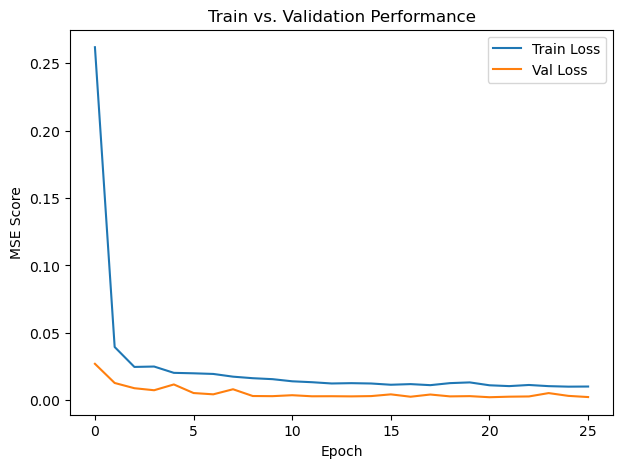

In [15]:
best_params = {
    'Units_hidden_layer_0': 170,
    'Units_hidden_layer_1': 180,
    'Units_hidden_layer_2': 130,
    'Units_hidden_layer_3': 120,
    'Units_hidden_layer_4': 90,
    #'Units_hidden_layer_5': 160,
    #'Units_hidden_layer_6': 200,
    #'Units_hidden_layer_7': 200,
    #'Units_hidden_layer_8': 180,
    #'Units_hidden_layer_9': 80,
    'Optimizer': 'Adamw',
    'Learning_Rate':0.0005256588893435302,
    'Activation': 'gelu',
    'alpha':  0.09546607173825271,
    'dropout': 0.1,
    'batch_size': 32
}
# 1. Extract the list_units from best_params
list_units = [
    best_params['Units_hidden_layer_0'],
    best_params['Units_hidden_layer_1'],
    best_params['Units_hidden_layer_2'],
    best_params['Units_hidden_layer_3'],
    best_params['Units_hidden_layer_4'],
    #best_params['Units_hidden_layer_5'],
    #best_params['Units_hidden_layer_6'],
    #best_params['Units_hidden_layer_7'],
    #best_params['Units_hidden_layer_8'],
    #best_params['Units_hidden_layer_9']
]

# 2. Create the model with best hyperparameters
tf_model = build_tf_model(
    nr_input_features=train_X.shape[1],
    list_units=list_units,
    dropout_rate=best_params['dropout'],
    activation=best_params['Activation'],
    alpha=best_params['alpha']
)

# 3. Set optimizer with best learning rate
tf_optimizer = tf.keras.optimizers.get({
    'class_name': best_params['Optimizer'],
    'config': {'learning_rate': best_params['Learning_Rate']}
})

# 4. Optional – set batch size
batch_size = best_params['batch_size']




train_dataset = tf.data.Dataset.from_tensor_slices((x_subtrain_train_scaled, y_subtrain_train_scaled)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val_train_scaled, y_val_train_scaled)).batch(batch_size)

train_loss_list = []
val_loss_list = [] 
best_val_loss = float('inf')
wait = 0
patience = 5
nr_epochs = 100
best_epoch = 0
final_epoch = nr_epochs

for epoch in range(nr_epochs):
    epoch_train_loss = []
    epoch_val_loss = []
    for x_batch_train, y_batch_train in train_dataset:
        train_loss = train_test_model(True, tf_model, x_batch_train, y_batch_train, tf_optimizer)
        epoch_train_loss.append(train_loss.numpy())
    
    epoch_mean_loss = np.mean(epoch_train_loss)
    train_loss_list.append(epoch_mean_loss)

    for x_batch_val, y_batch_val in val_dataset:
        val_loss = train_test_model(False, tf_model, x_batch_val, y_batch_val)
        epoch_val_loss.append(val_loss.numpy())

    mean_val_loss = np.mean(epoch_val_loss)
    val_loss_list.append(mean_val_loss)

    
    if mean_val_loss < best_val_loss:
        best_val_loss = mean_val_loss
        best_epoch = epoch
        wait = 0
    else:
        wait += 1

    if wait >= patience:
        final_epoch=epoch
        break



print(f"Training stopped at epoch {final_epoch}, best epoch: {best_epoch}, best val loss: {best_val_loss:.4f}")
# Visualize the model performance:
plt.figure(figsize=(7,5))
plt.plot(train_loss_list,label='Train Loss')
plt.plot(val_loss_list,label='Val Loss')
plt.ylabel('MSE Score')
plt.xlabel('Epoch')
plt.title('Train vs. Validation Performance')#
plt.legend()
plt.show()
plt.close()

In [35]:
from sklearn.metrics import mean_squared_error
# Convert validation set to full tensor
x_val_train_tensor = tf.convert_to_tensor(x_val_train_scaled, dtype=tf.float32)

# Predict using trained model
y_pred_scaled = tf_model(x_val_train_tensor).numpy()

y_pred_rescaled = y_scalar.inverse_transform(y_pred_scaled)
y_true_rescaled = y_scalar.inverse_transform(y_val_train_scaled)
mse_original = mean_squared_error(y_true_rescaled, y_pred_rescaled)
test_rmse = np.sqrt(mean_squared_error(y_true_rescaled, y_pred_rescaled))
print("Test MSE_NN-T",mse_original,
    "Test_RMSE_NN_T:", test_rmse)
Test_RMSE_NN_T=test_rmse


Test MSE_NN-T 222.45135906511973 Test_RMSE_NN_T: 14.914803353216554


Model Comparison Table

In [36]:
#Creat RMSE comparision table
rmse_table = pd.DataFrame({
    'Model': ['Ridge Regression', 'Random Forest', 'Neural Network (Baseline)', 'Neural Network (Tuned)'],
    'Validation RMSE': [Validation_RMSE_Ridge,Validation_RMSE_rf ,Validation_RMSE_NN_non,Test_RMSE_NN_T]})

#print(rmse_table)
rmse_table.style.set_caption("Validation RMSE Comparison Table") \
    .format({"Validation RMSE": "{:.2f}"}) \
    .background_gradient(subset=["Validation RMSE"], cmap="YlGn") 

,Model,Validation RMSE
0,Ridge Regression,39.59
1,Random Forest,20.79
2,Neural Network (Baseline),23.82
3,Neural Network (Tuned),14.91


Prediction on Test Set and Export of Results

In [38]:

# Predict the test_y
y_pred_scaled = tf_model.predict(x_test_scaled)
#  Inverse transform to original scale
y_pred_rescaled = y_scalar.inverse_transform(y_pred_scaled)

prediction_df = pd.DataFrame({
    'predicted_y': y_pred_rescaled.flatten()  # flatten() to make it a 1D array
})
# output predictions
prediction_df.to_csv('predictions_y.csv', index=False)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Why is this architeture suitable for my task?
The five layers with gradually decreasing neurons(170-180-130-120-90) can captures complex patterns in the data. Gelu Guassian error linear unit can smooth the transformation, and AdamW optimizer improve the model generalization.The appropriate dropout rate and L2 regularization prevent overfitting, balancing the model complexity and generalization.

 Based on the plot you should interpret the model fit with max. 2 sentences. 
Both the validation loss and training loss decrease smoothly and converge to a low MSE. The lower validation loss indicates that the model achieves good regularization without signs of overfitting.